In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
np.random.seed(0)
X_train = np.random.rand(200, 2) * 2 - 1
y_train = np.logical_xor(X_train[:, 0] > 0, X_train[:, 1] > 0).astype(int) * 2 - 1

X_test = np.random.rand(200, 2) * 2 - 1
y_test = np.logical_xor(X_test[:, 0] > 0, X_test[:, 1] > 0).astype(int) * 2 - 1 

X_val = np.random.rand(200, 2) * 2 - 1
y_val = np.logical_xor(X_val[:, 0] > 0, X_val[:, 1] > 0).astype(int) * 2 - 1 

In [3]:
def plot_decision_surface(model, X, y, title, poly=None):
    h = .02  
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    if poly is None:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    else:
        transformed = poly.transform(np.c_[xx.ravel(), yy.ravel()])
        transformed = np.delete(transformed, 0, axis=1)
        Z = model.predict(transformed)
    
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

MLP accuracy: 0.98


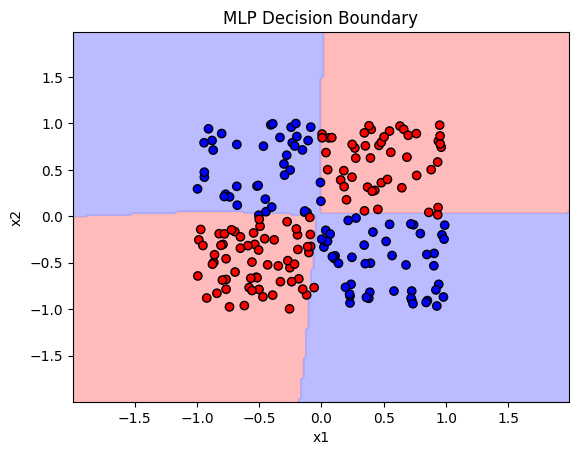

In [4]:
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam',max_iter=2000, random_state= 0)
mlp.fit(X_train, y_train)
print(f"MLP accuracy: {mlp.score(X_test, y_test)}")
plot_decision_surface(mlp, X_test, y_test, title="MLP Decision Boundary")

In [5]:
def line_search(alpha_range):
    best_alpha = None
    best_criterion = float('-inf')

    for alpha in alpha_range:
        mlp_l2 = MLPClassifier(hidden_layer_sizes=(10,), max_iter=2000, random_state=0, alpha=alpha, solver='adam', activation='relu')
        mlp_l2.fit(X_train, y_train)
        accuracy = mlp_l2.score(X_val, y_val)
        print(f"Accuracy with penalty coefficient {alpha}: {accuracy}")
        if accuracy > best_criterion:
            best_alpha = alpha
            best_criterion = accuracy

    return best_alpha

alpha_range = [0, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]

best_alpha = line_search(alpha_range)
print(f"The best alpha value is: {best_alpha}")


Accuracy with penalty coefficient 0: 0.96
Accuracy with penalty coefficient 0.001: 0.96
Accuracy with penalty coefficient 0.01: 0.96
Accuracy with penalty coefficient 0.1: 0.96
Accuracy with penalty coefficient 0.5: 0.955
Accuracy with penalty coefficient 1.0: 0.95
Accuracy with penalty coefficient 2.0: 0.945
Accuracy with penalty coefficient 10.0: 0.8
The best alpha value is: 0


MLP accuracy: 0.98


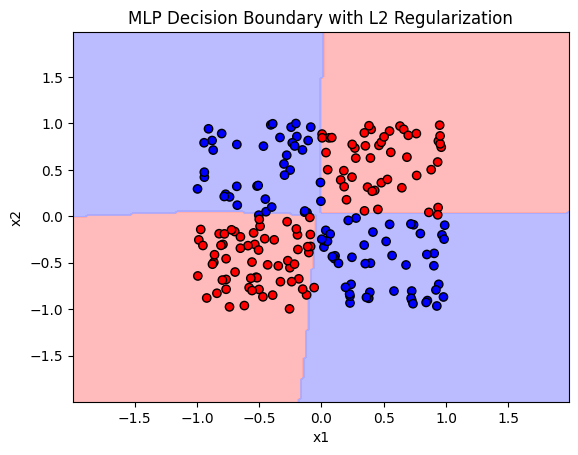

In [6]:
mlp_l2 = MLPClassifier(hidden_layer_sizes=(10,), max_iter=2000, random_state=0, alpha=best_alpha, solver='adam', activation='relu')
mlp_l2.fit(X_train, y_train)
print(f"MLP accuracy: {mlp_l2.score(X_test, y_test)}")
plot_decision_surface(mlp_l2, X_test, y_test, title="MLP Decision Boundary with L2 Regularization")

Logistic regression with additional features accuracy: 0.95


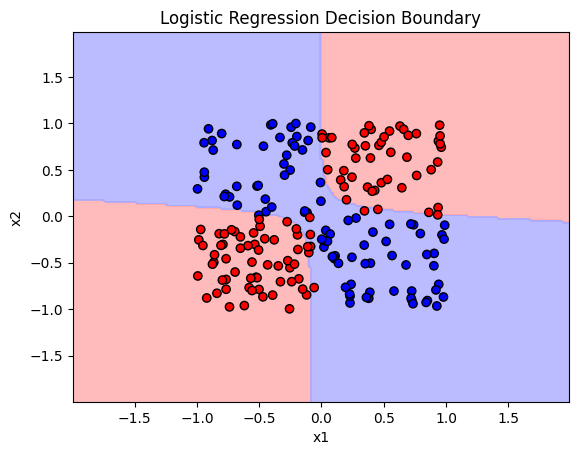

In [7]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_poly = np.delete(X_train_poly, 0, axis=1)
X_test_poly = np.delete(X_test_poly, 0, axis=1)

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_poly, y_train)
print("Logistic regression with additional features accuracy:", log_reg.score(X_test_poly, y_test))

plot_decision_surface(log_reg, X_test_poly, y_test, title="Logistic Regression Decision Boundary", poly=poly)


In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [9]:
y_train_tensor = torch.where(y_train_tensor == -1, torch.tensor(0), y_train_tensor)
y_test_tensor = torch.where(y_test_tensor == -1, torch.tensor(0), y_test_tensor)

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

model = MLP()
num_epochs = 200
l1_lamba = 0.001
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.01)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    l1_regularization = 0
    for params in model.parameters():
        l1_regularization += torch.norm(params, p=1)
    loss += l1_regularization * l1_lamba
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"The loss at epoch {epoch + 1}: {loss.item()}")

The loss at epoch 10: 0.6874439120292664
The loss at epoch 20: 0.6606870293617249
The loss at epoch 30: 0.6275200247764587
The loss at epoch 40: 0.5871350765228271
The loss at epoch 50: 0.541326105594635
The loss at epoch 60: 0.49063295125961304
The loss at epoch 70: 0.43889090418815613
The loss at epoch 80: 0.38982465863227844
The loss at epoch 90: 0.3462563753128052
The loss at epoch 100: 0.3101519048213959
The loss at epoch 110: 0.28123292326927185
The loss at epoch 120: 0.25802960991859436
The loss at epoch 130: 0.23860734701156616
The loss at epoch 140: 0.22193273901939392
The loss at epoch 150: 0.20744305849075317
The loss at epoch 160: 0.1947946697473526
The loss at epoch 170: 0.18364587426185608
The loss at epoch 180: 0.17386451363563538
The loss at epoch 190: 0.16565339267253876
The loss at epoch 200: 0.1587909460067749


In [11]:
outputs = model(X_test_tensor)
predicted_labels = (outputs > 0.5).float()
accuracy = (predicted_labels == y_test_tensor).float().mean().item()
print(f"Accuracy: {accuracy}")

Accuracy: 0.9549999833106995


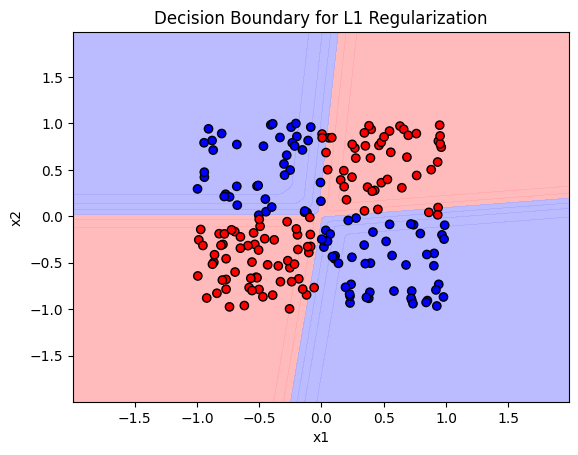

In [19]:
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    grid_tensor = torch.tensor(np.c_[xx1.ravel(), xx2.ravel()], dtype=torch.float32)
    Z = model(grid_tensor)
    Z = Z.detach().numpy().reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolor='k')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Decision Boundary for L1 Regularization')
    plt.show()

plot_decision_boundary(model, X_test_tensor, y_test_tensor)


In [ ]:
def plot_decision_surface(model, X, y, title, poly=None):
    h = .02  
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    if poly is None:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    else:
        transformed = poly.transform(np.c_[xx.ravel(), yy.ravel()])
        transformed = np.delete(transformed, 0, axis=1)
        Z = model.predict(transformed)
    
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()